In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import optuna
from jupyterthemes import jtplot
from mapie.regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap
from lightgbm import LGBMRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error,r2_score

jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)
sns.set_theme()

Loading electricity demand data for Monterrey location retrieved from CENACE website

In [175]:
demandaMTY = pd.read_csv('df_fullMTY.csv')
demandaMTY['Fecha'] = pd.to_datetime(demandaMTY['Fecha'])
demandaMTY.set_index('Fecha', inplace=True)
demandaMTY = demandaMTY.loc[(demandaMTY.index >= '2018-01-02') & (demandaMTY.index <= '2022-12-31')]

Loading electricity price data retrieved also from CENACE website

In [176]:
pmlMTY = pd.read_csv('PMLMTY2016_2023.csv')
pmlMTY['Fecha'] = pd.to_datetime(pmlMTY['Fecha'])
pmlMTY.set_index('Fecha', inplace=True)
pmlMTY = pmlMTY.loc[(pmlMTY.index >= '2018-01-02') & (pmlMTY.index <= '2022-12-31')]
pmlMTY.rename(columns={'Precio marginal local ($/MWh)':'PML'}, inplace=True)

As obtained from electricity price data analysis, it will be used the lags from 14, 15 and 16 days prior.

In [177]:
pmlMTYlag = pmlMTY.copy()
pmlMTYlag['PMLlag14'] = pmlMTYlag['PML'].shift(6)#14
pmlMTYlag['PMLlag15'] = pmlMTYlag['PML'].shift(13)#15
pmlMTYlag['PMLlag16'] = pmlMTYlag['PML'].shift(20)#16

Temperature variations ranging from 2018 thru 2022 fro Monterrey were obtained from NOAA (https://www.ncei.noaa.gov/cdo-web/)

In [178]:
tempMTY = pd.read_csv('WeatherMTY2017_2023.csv')
tempMTY['DATE'] = pd.to_datetime(tempMTY['DATE'])
tempMTY.set_index('DATE', inplace=True)
tempMTY = tempMTY.loc[(tempMTY.index >= '2018-01-02') & (tempMTY.index <= '2022-12-31')]
tempMTY.drop(columns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION','PRCP_ATTRIBUTES','TAVG_ATTRIBUTES','TMAX_ATTRIBUTES','TMIN_ATTRIBUTES', 'PRCP','TMAX','TMIN'], inplace=True)

Contatenate all data into a single dataframe

In [179]:
demandaMTY_full = demandaMTY.copy()
demandaMTY_full = pd.concat([demandaMTY_full,pmlMTYlag, tempMTY['TAVG']], axis=1)

Create function to create features tha will be used in LGBM model

In [180]:
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    return df

Define function to create lags features for electricity demand data

In [181]:
def add_lags(df):
    df['lag1'] = df[' Energia (MWh) '].shift(1)
    df['lag7'] = df[' Energia (MWh) '].shift(7)
    return df

Create function to calculate statistic metrics for the model

In [182]:
def calculate_model_accuracy_metrics(actual, predicted):
    mape = mean_absolute_percentage_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    return mape*100,mae,mse,rmse,r2

Create function to calculate Conformal Prediction metrics

In [183]:
def calculate_metricsforCP(y_true, lower_bound, upper_bound, alpha=0.05):

    coverage_probability_conformal = np.mean((y_true >= lower_bound) & (y_true <= upper_bound))
    coverage_indicator = ((lower_bound <= y_true) & (y_true <= upper_bound)).astype(int)

    validity = abs(coverage_probability_conformal - alpha)
    sharpness = np.mean(upper_bound - lower_bound)
    interval_score = sharpness + (1 / len(y_true)) * coverage_indicator.sum()

    return validity,sharpness,interval_score

Prepare data for LGBM model

In [184]:
dataforlgbm = demandaMTY_full.copy()
train = dataforlgbm.loc[(dataforlgbm.index >= '2018-01-02') & (dataforlgbm.index <= '2021-12-31')]
test = dataforlgbm.loc[(dataforlgbm.index >= '2022-01-01') & (dataforlgbm.index <= '2022-12-31')]

trainlgbm = create_features(train)
testlgbm = create_features(test)

trainlgbm = add_lags(trainlgbm)
testlgbm = add_lags(testlgbm)

FEATURES = ['dayofweek','lag1','lag7','PMLlag14','PMLlag15','PMLlag16','TAVG']
TARGET = [' Energia (MWh) ']

X_train = trainlgbm[FEATURES]
y_train = trainlgbm[TARGET]

X_test = testlgbm[FEATURES]
y_test = testlgbm[TARGET]

Plotting electricity demand data showing the train and test sets

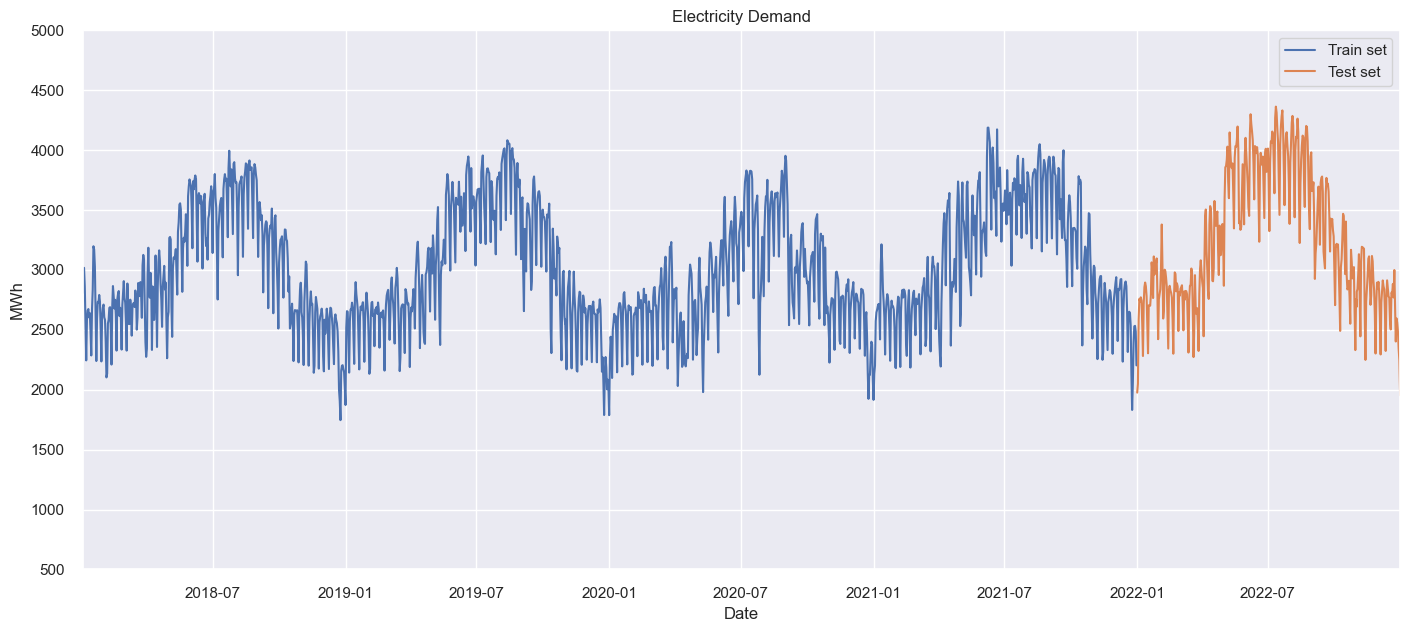

In [185]:
plt.figure(figsize=(17, 7))
plt.plot(X_train.index, y_train.values, label="Train set")
plt.plot(X_test.index, y_test.values, label="Test set")
plt.title("Electricity Demand")
plt.xlabel("Date")
plt.ylabel("MWh")
plt.xlim([X_train.index.min(), X_test.index.max()])
plt.ylim([500, 5000])
plt.legend()
plt.show();

****************** LGBM model definition *******************

Perform grid search to find best parameters for the model using optuna

In [186]:
# X_train_optuna_final = X_train[0:1461]
# y_train_optuna_final = y_train[0:1461]
# X_val_optuna_final = X_train[1461:]
# y_val_optuna_final = y_train[1461:]
# def objective(trial):
#     params = {
#         "linear_tree": trial.suggest_categorical("linear_tree", [False]),
#         "n_estimators": 404,
#         "learning_rate":trial.suggest_float("learning_rate", 0.1, 0.3),
#         "max_depth":trial.suggest_int("max_depth", 1, 5),
#         "num_leaves":trial.suggest_int("num_leaves", 2000, 4000),
#         "max_bin":trial.suggest_int("max_bin", 100, 200),
#         "min_child_samples":177,
#         "verbose" : -1,
#     }

#     model = LGBMRegressor(**params)
#     model.fit(X_train_optuna_final, y_train_optuna_final)
#     predictions = model.predict(X_val_optuna_final)
#     rmse = mean_squared_error(y_val_optuna_final, predictions, squared=False)
#     return rmse

In [187]:
# import warnings
# warnings.filterwarnings("ignore")

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)
# print('Best hyperparameters:', study.best_params)
# print('Best RMSE:', study.best_value)

LGBM model definition using the best parameters

In [188]:
#Best hyperparameters: {'n_estimators': 404, 
#                       'learning_rate': 0.253, 
#                       'max_depth': 4, 
#                       'num_leaves': 3058, 
#                       'max_bin': 172, 
#                       'min_child_samples': 177}
import warnings
warnings.filterwarnings("ignore")
#'n_estimators': 437, 'learning_rate': 0.14700750726755848, 'max_depth': 1, 'num_leaves': 3994, 'max_bin': 264, 'min_child_samples': 207
reg = LGBMRegressor( objective='regression',
                       metric='mse',
                        linear_tree=False,
                        n_estimators= 404,
                        learning_rate=0.101,
                        max_depth=1,
                        num_leaves=2795,
                        max_bin=129,
                        min_child_samples=177,
                        verbose=-1,
                        random_state = 101
                       )
reg.fit(X_train, y_train,
eval_set=[(X_train, y_train), (X_test, y_test)])

LGBMRegressor(learning_rate=0.101, linear_tree=False, max_bin=129, max_depth=1,
              metric='mse', min_child_samples=177, n_estimators=404,
              num_leaves=2795, objective='regression', random_state=101,
              verbose=-1)

Calculate the prediction for the test set

In [189]:
y_pred = reg.predict(X_test)

Calculate Shapley values for the model

In [190]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(reg)
shap_values = explainer(X_train)
i_med = np.argsort(y_pred)[len(y_pred)//2]
explainer.expected_value, np.mean(y_train)

(3001.3298501180743, 3001.3298512361102)

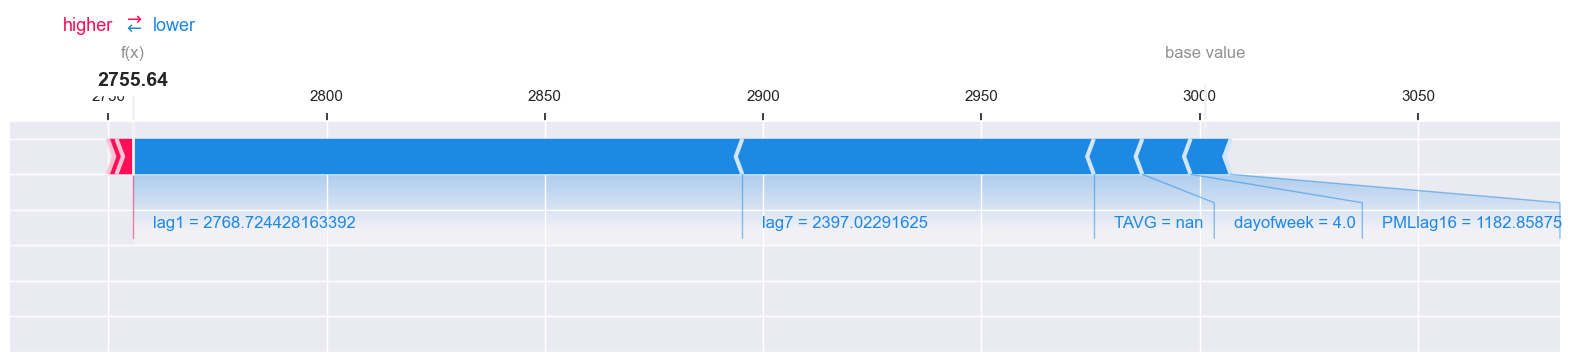

In [191]:
shap.plots.force(shap_values[i_med], show=False, matplotlib=True)
plt.gcf()
plt.show();

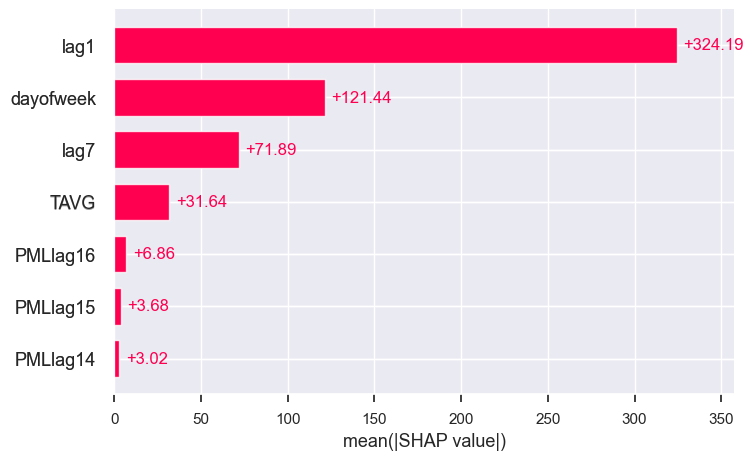

In [192]:
shap.plots.bar(shap_values, max_display=99, show=False)
plt.gcf()
plt.show()

Plotting prediction values vs real values of test set

(18993.0, 19358.0)

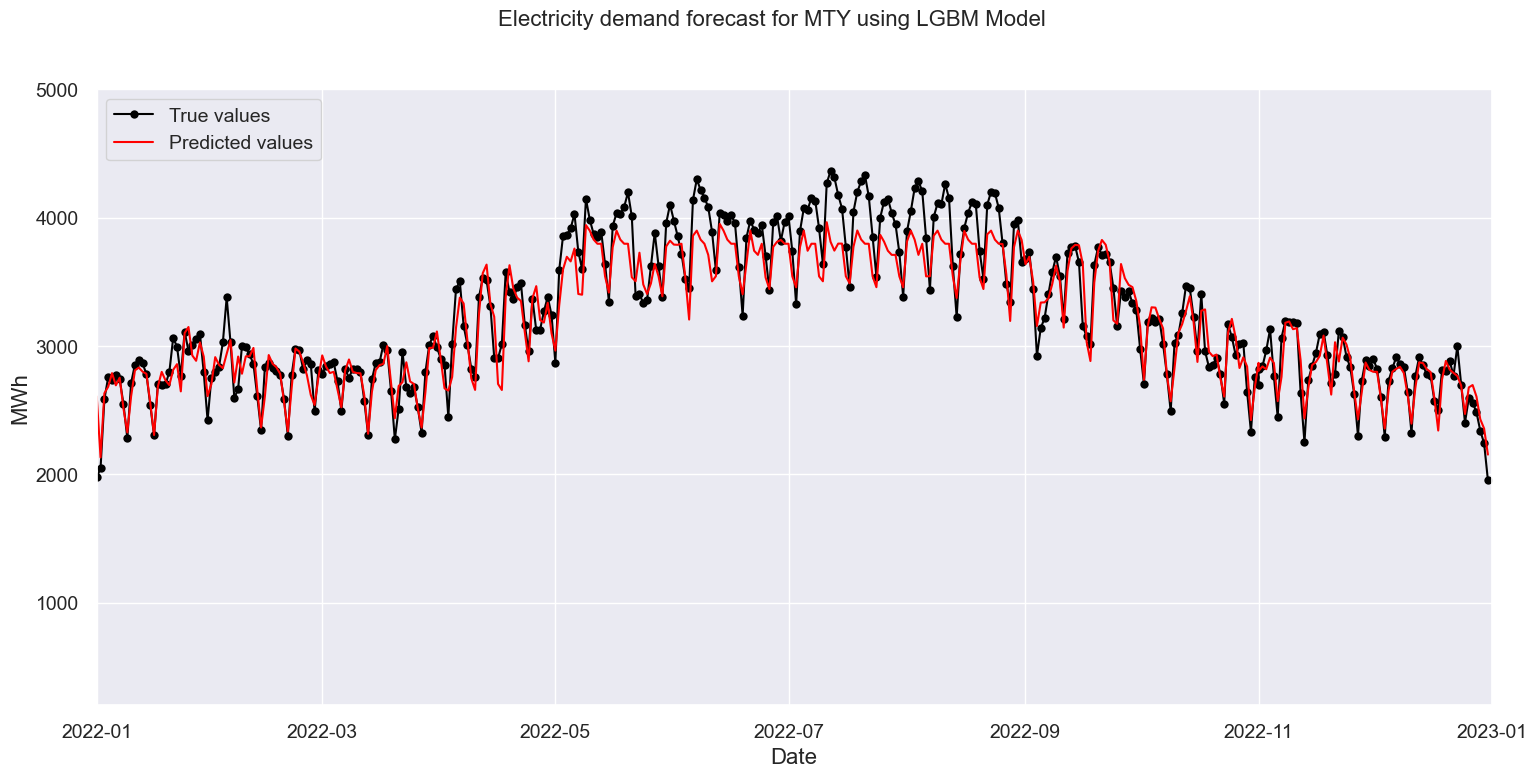

In [165]:
fig, (ax1) = plt.subplots(figsize=(18,8),sharex=True)
fig.suptitle('Electricity demand forecast for MTY using LGBM Model', fontsize=16)
ax1.plot(y_test.index, y_test.values, marker='o', label="True values", color='black')
ax1.plot(y_test.index, y_pred, label="Predicted values", color='red')
ax1.legend(loc='upper left', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylim([200, 5000])
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('MWh', fontsize=16)
ax1.set_xlim([datetime.date(2022, 1, 1), datetime.date(2023,1,1)])

Calculate premiliary metrics for the model

In [166]:
mape,mae,mse,rmse,r2 = calculate_model_accuracy_metrics(y_test.values,y_pred)
mape,mae,mse,rmse,r2

(4.081043854527923,
 137.46862532558262,
 33107.347113041775,
 181.95424455901482,
 0.8949860127525314)

Performing isotonic regression to calibrate the model

In [167]:
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
y_testreshape = y_test.copy()
y_testreshape = y_testreshape.values.reshape(-1)
ir = IsotonicRegression(out_of_bounds='clip')
ir.fit(y_pred, y_testreshape)

y_pred_calibrated_iso = ir.predict(y_pred)

Plot isotonic regression calibration

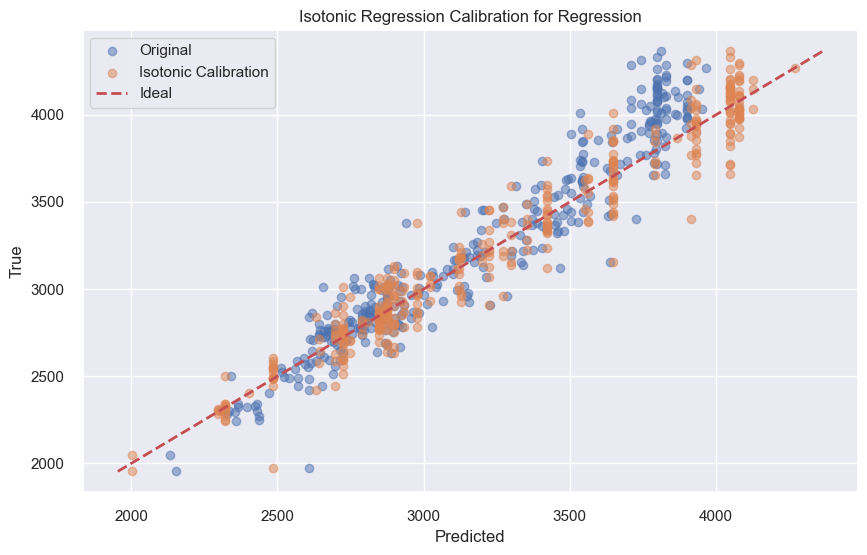

In [168]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_testreshape, alpha=0.5, label='Original')
plt.scatter(y_pred_calibrated_iso, y_testreshape, alpha=0.5, label='Isotonic Calibration')
plt.plot([y_testreshape.min(), y_testreshape.max()], [y_testreshape.min(), y_testreshape.max()], 'r--', lw=2, label='Ideal')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Isotonic Regression Calibration for Regression')
plt.legend()
plt.show()

Calculate Conformal Prediction intervals using MAPIE

In [169]:
alpha = 0.05
gap = 1

mapie_cv = BlockBootstrap(n_blocks=10, overlapping=True, random_state=42)

mapie_enbpi = MapieTimeSeriesRegressor(
    reg, method="enbpi", cv=mapie_cv, agg_function="mean", n_jobs=-1
)

In [170]:
mapie_enbpi = mapie_enbpi.fit(X_train, y_train.values.ravel())
y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(
    X_test.values, alpha=alpha, ensemble=True, optimize_beta=True
)
coverage_npfit = regression_coverage_score(
    #y_test, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
    y_pred_calibrated_iso, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)
width_npfit = regression_mean_width_score(y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0])

Plotting forecast with Conformal Prediction intervals

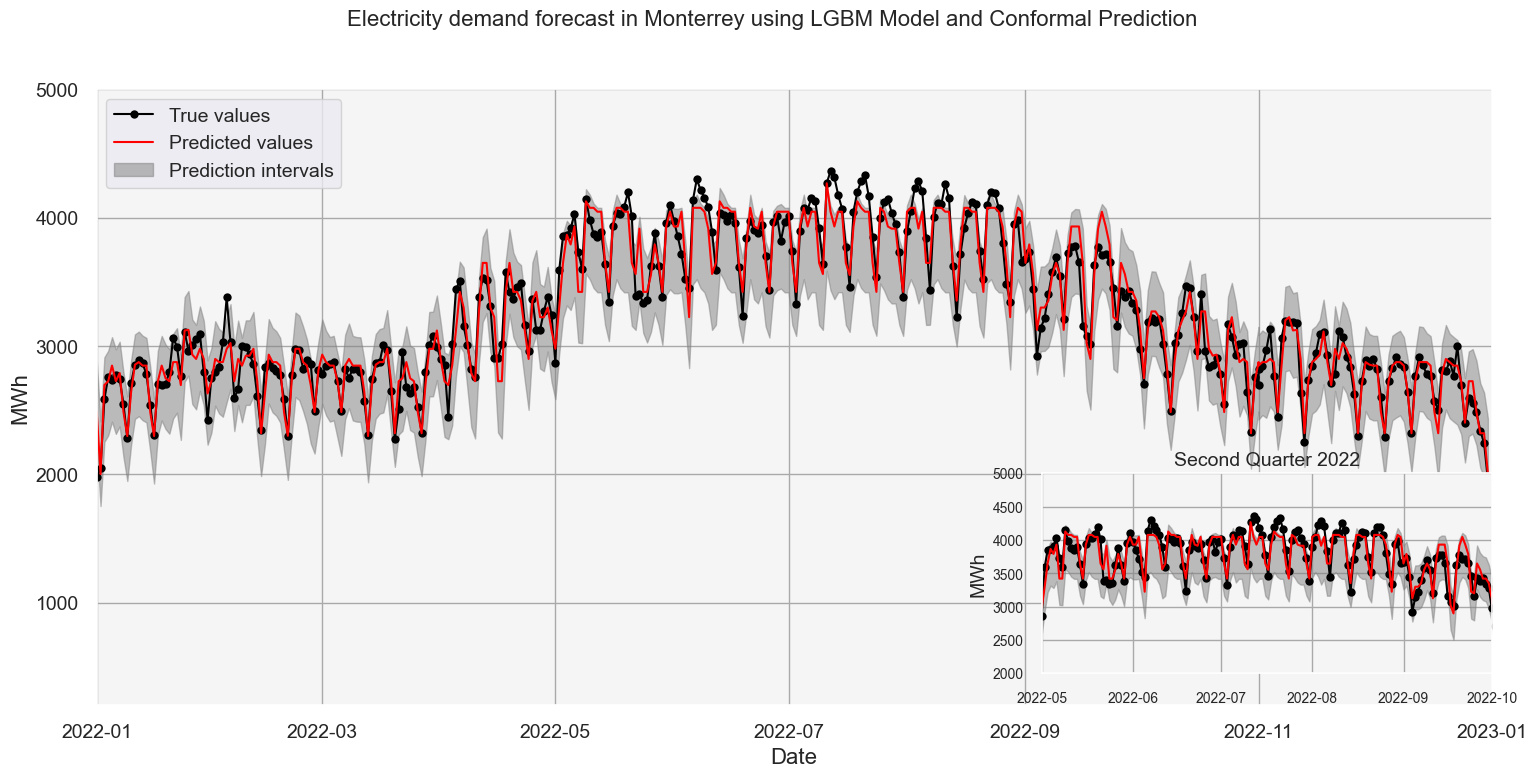

In [171]:
import matplotlib as mpl
mpl.rcParams['grid.color'] = 'darkgray'
fig, (ax1) = plt.subplots(figsize=(18,8),sharex=True)
fig.suptitle('Electricity demand forecast in Monterrey using LGBM Model and Conformal Prediction', fontsize=16)
ax1.set_facecolor('whitesmoke')
ax1.plot(y_test.index, y_test.values, marker='o', label="True values", color='black')
ax1.plot(y_test.index, y_pred_calibrated_iso, label="Predicted values", color='red')
ax1.fill_between(
    y_test.index,
    y_pis_npfit[:, 0, 0],
    y_pis_npfit[:, 1, 0],
    alpha=0.5,
    label="Prediction intervals",
    color='gray'
)
ax1.legend(loc='upper left', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylim([200, 5000])
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('MWh', fontsize=16)
ax1.set_xlim([datetime.date(2022, 1, 1), datetime.date(2023,1,1)])

left, bottom, width, height = [0.65, 0.15, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height], facecolor='whitesmoke')
ax2.plot(y_test.index, y_test.values, marker='o', color='black')
ax2.plot(y_test.index, y_pred_calibrated_iso, color='red')
ax2.fill_between(
    y_test.index,
    y_pis_npfit[:, 0, 0],
    y_pis_npfit[:, 1, 0],
    alpha=0.5,
    color='gray'
)
ax2.set_ylabel('MWh', fontsize=14)
ax2.set_title('Second Quarter 2022', fontsize=14)
ax2.set_ylim([2000, 5000])
ax2.set_xlim([datetime.date(2022, 5, 1), datetime.date(2022,10,1)])
ax2.tick_params(axis='both', which='major', bottom=False, top=False, labelbottom=True,  labelsize=10)
ax2.grid(True)
#plt.savefig('Fig4_LGBM_forecast_CP.svg',format='svg',dpi=1200)

Calculate Conformal Prediction metrics

In [172]:
lower_bound = y_pis_npfit[:, 0, 0]
upper_bound = y_pis_npfit[:, 1, 0]
y_true = y_test.values

validity,sharpness,interval_score = calculate_metricsforCP(y_true, lower_bound, upper_bound)

Arrange results in a dataframe for ease of reading

In [173]:
pd.options.display.float_format = '{:.2f}'.format
mape,mae,mse,rmse,r2 = calculate_model_accuracy_metrics(y_test.values,y_pred_calibrated_iso) #
modeloLGBM = pd.DataFrame(data=(mape,mae,mse,rmse,r2,coverage_npfit*100,validity,sharpness,interval_score), index=['MAPE (%)', 'MAE','MSE','RMSE','R2','Coverage (%)','Validity','Sharpness','Interval Score'])
modeloLGBM = modeloLGBM.rename(columns={0: 'Metrics'})
modeloLGBM

,Metrics
MAPE (%),3.05
MAE,99.20
MSE,17980.12
RMSE,134.09
R2,0.94
Coverage (%),99.73
Validity,0.29
Sharpness,658.64
Interval Score,782.09
